Activity 1
Analog IC Characterization: The Wideband RC Voltage-Divider

I. INTRODUCTION

The frequency-independent signal attenuator is a fundamental building block in high-bandwidth analog measurement systems, where accurate signal scaling must be maintained over a wide range of frequencies. Simple resistive voltage dividers, while effective at low frequencies, often exhibit frequency-dependent behavior when parasitic capacitances and source or load impedances are introduced. These effects become especially pronounced in wideband applications, leading to signal distortion, amplitude errors, and phase shift.

To address these limitations, RC compensation techniques are employed. By intentionally adding capacitive elements in parallel with resistive components, the frequency response of the divider can be shaped to achieve flat attenuation across a broad spectrum. This principle is widely used in practical instrumentation such as oscilloscope probes, data acquisition front-ends, and analog integrated circuits, where maintaining signal integrity is critical.

This laboratory activity examines the wideband RC voltage divider as a representative analog IC building block. Students will explore the theoretical basis of RC compensation, including pole-zero cancellation and time-constant matching, and observe how these concepts translate into real circuit behavior. Emphasis is placed on understanding how component values influence bandwidth, transient response, and overall signal fidelity.

In addition to theory, the laboratory integrates circuit simulation using NGSPICE within a Visual Studio Code (VS Code) workflow. This environment mirrors modern engineering practice by combining schematic-level analysis with script-based simulation and waveform inspection. Through simulation, students will characterize both uncompensated and compensated dividers in the time and frequency domains, reinforcing the connection between mathematical models and observable circuit performance.

II. MATERIALS AND EQUIPMENT

Computing Workstation (PC or Laptop)

Integrated Development Environment (IDE): Visual Studio Code

NGSPICE Simulator: (Version 42+)

Python 3.x (pandas, matplotlib, numpy, schemdraw)

III. PROCEDURES

PHASE 1: INSTALLATION & SYSTEM CONFIGURATION

Step 1: Install NGSPICE (The Simulator)

    Download ngspice-42_64.zip from the NGSPICE SourceForge page.

    Extract the file and copy the Spice64 folder.

    Paste it directly into the C: drive:

            C:\Spice64
    
    Verify that ngspice.exe exists in:

            C:\Spice64\bin

Step 2: Add NGSPICE to Windows PATH

    Copy Path:

        C:\Spice64\bin

    Open Edit the system environment variables.

    Under System variables → Path → Edit → New, paste the path.

    Click OK to save.

Step 3: Verify in VS Code

    Restart VS Code.

    Open the terminal (Ctrl + `).

    Run:

        ngspice -v
    
    The NGSPICE version output confirms successful installation.

PHASE 2: PYTHON ENVIRONMENT SETUP
Install Required Python Libraries

Purpose:
These libraries will be used for circuit visualization (schemdraw), data handling (pandas), numerical analysis (numpy), and plotting simulation results (matplotlib).

In [18]:
pip install schemdraw pandas matplotlib numpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Verify NGSPICE Availability

Purpose:
Confirms that NGSPICE is correctly installed and accessible from the Jupyter Notebook environment before running simulations.

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import os

# Robust verification: This checks if NGSPICE is accessible
try:
    result = subprocess.run(["ngspice", "-v"], capture_output=True, text=True)
    if result.stdout:
        # Print the first available line of the version info
        print(f"NGSPICE Found: {result.stdout.splitlines()[0]}")
    else:
        print("NGSPICE executed but returned no version text.")
except FileNotFoundError:
    print("ERROR: NGSPICE not found. Please check your Windows PATH and restart VS Code.")

NGSPICE executed but returned no version text.


PHASE 3: CIRCUIT SCHEMATIC VISUALIZATION
Draw RC Divider Circuit

Purpose:
This cell visualizes the wideband RC voltage divider, showing:
    R1 with compensation capacitor C1
    Load resistor R2 and load capacitor C2
    Input Vin and output Vout nodes

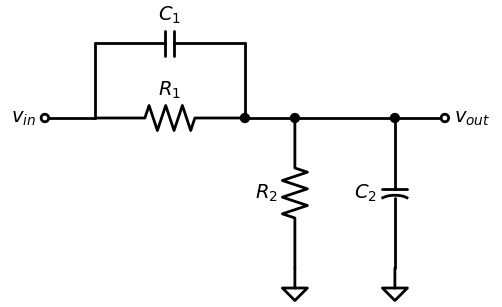

In [20]:
import schemdraw
import schemdraw.elements as elm

with schemdraw.Drawing() as d:
    d += (vin := elm.Dot(open=True).label('$v_{in}$', loc='left'))
    d += elm.Line().right().length(1)
    d.push()
    d += elm.Resistor().label('$R_1$')
    d.pop()
    d += elm.Line().up().length(1.5)
    d += elm.Capacitor().right().label('$C_1$')
    d += elm.Line().down().length(1.5)
    d += elm.Dot()
    d += elm.Line().right().length(1)
    d.push()
    d += elm.Resistor().down().label('$R_2$')
    d += elm.GroundSignal()
    d.pop()
    d += elm.Dot()
    d += elm.Line().right().length(2)
    d.push()
    d += elm.Capacitor2().down().label('$C_2$')
    d += elm.GroundSignal()
    d.pop()
    d += elm.Dot()
    d += elm.Line().right().length(1)
    d += elm.Dot(open=True).label('$v_{out}$', loc='right')

PHASE 4: NGSPICE NETLIST GENERATION & SIMULATION
Generate Netlist, Run Simulation, and Verify Output

Purpose:
    Generates a complete NGSPICE netlist using Python-defined component values.
    Runs AC and transient analyses in batch mode.
    Verifies that data files (output_ac.dat, output_tran.dat) are created for further plotting and analysis.

In [54]:
spice_netlist = """* Wideband RC Voltage Divider
.options savecurrents

* Main Circuit
R1 in out 5.6M
R2 out 0 330k
C1 in out 12.9643p
C2 out 0 220p

* Variations
R1a in outa 5.6M
R2a outa 0 330k
C1a in outa 14.26073p
C2a outa 0 220p

R1b in outb 5.6M
R2b outb 0 330k
C1b in outb 11.66787p
C2b outb 0 220p

V1 in 0 pulse(-0.1 0.1 0 0.1u 0.1u 5u 10u) dc 1 ac 1

.control
  ac dec 10 1 1G
  wrdata output_ac.dat v(out) v(outa) v(outb)
  
  tran 0.01u 30u
  wrdata output_tran.dat v(out) v(outa) v(outb)
  quit
.endc
.end
"""

with open("netlist.spice", "w") as f:
    f.write(spice_netlist)
print("netlist.spice created.")

netlist.spice created.


RUN SIMULATION WITH FILE CLEANUP
Ensure Fresh Simulation and Verify Output

Purpose:

    Ensures old simulation files are removed before running a new simulation.
    Runs NGSPICE in batch mode and verifies that AC and transient data files are generated.
    Provides immediate feedback if something goes wrong.

In [55]:
import subprocess
import os

# Remove old files to be sure we are seeing new results
for f in ["output_ac.dat", "output_tran.dat"]:
    if os.path.exists(f):
        os.remove(f)

try:
    # Running in batch mode
    subprocess.run(["ngspice", "-b", "netlist.spice"], check=True)
    
    if os.path.exists("output_tran.dat"):
        print("Success! Simulation finished and data files are ready.")
    else:
        print("Simulation finished but no data files were found.")
except subprocess.CalledProcessError as e:
    print(f"Simulation failed with error code {e.returncode}")

Success! Simulation finished and data files are ready.


PHASE 5: PLOT TRANSIENT RESPONSE
    Read and Plot Transient Data

Data detected: 6 columns


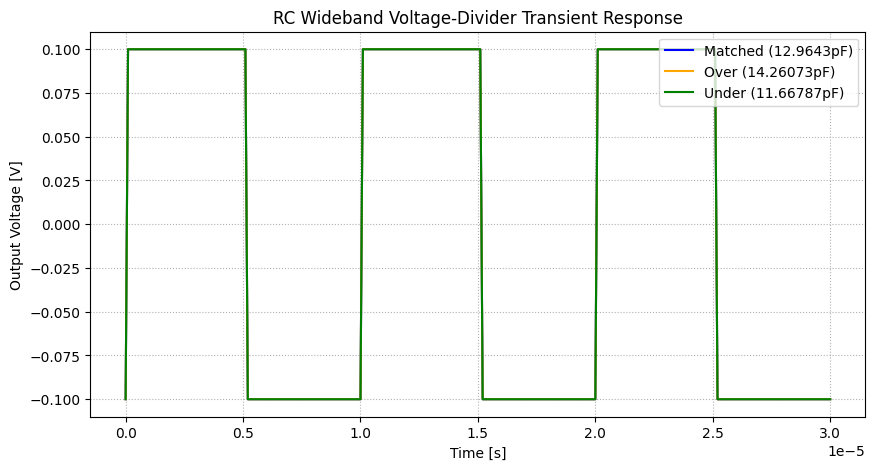

In [56]:
# Read the file without specifying columns first
df_tran = pd.read_csv("output_tran.dat", sep='\\s+', header=None)

# Let's check the shape to be safe
print(f"Data detected: {df_tran.shape[1]} columns")

# NGSPICE often exports: Time, Vout, Time, VoutA, Time, VoutB
# We only need the first Time and the Voltages
if df_tran.shape[1] == 6:
    df_tran.columns = ["time", "vout", "time2", "vouta", "time3", "voutb"]
elif df_tran.shape[1] == 4:
    df_tran.columns = ["time", "vout", "vouta", "voutb"]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df_tran['time'], df_tran['vout'], label="Matched (12.9643pF)", color='blue')
plt.plot(df_tran['time'], df_tran['vouta'], label="Over (14.26073pF)", color='orange')
plt.plot(df_tran['time'], df_tran['voutb'], label="Under (11.66787pF)", color='green')

plt.title("RC Wideband Voltage-Divider Transient Response")
plt.xlabel("Time [s]")
plt.ylabel("Output Voltage [V]")
plt.legend(loc='upper right')
plt.grid(True, linestyle='dotted')
plt.show()

PHASE 6: READ FREQUENCY RESPONSE DATA
Read AC Simulation Output

Purpose:
    Loads NGSPICE AC simulation results into a pandas DataFrame.
    Handles multiple output nodes and varying file formats.
    Prepares the data for plotting frequency-domain response in the next cell.

In [59]:
# @title Read in SPICE frequency response data
df_ac = pd.read_csv("output_ac.dat", sep='\\s+', header=None)

# Handle the 9-column format (Frequency repeated for each node)
if df_ac.shape[1] == 9:
    df_ac.columns = [
        "freq", "vout_re", "vout_im", 
        "freq2", "vouta_re", "vouta_im", 
        "freq3", "voutb_re", "voutb_im"
    ]
elif df_ac.shape[1] == 7:
    df_ac.columns = ["freq", "vout_re", "vout_im", "vouta_re", "vouta_im", "voutb_re", "voutb_im"]

df_ac.head()

,freq,vout_re,vout_im,freq2,vouta_re,vouta_im,freq3,voutb_re,voutb_im
0,1.000000,1.0,-7.740884e-12,1.000000,1.0,-7.740884e-12,1.000000,1.0,-7.740884e-12
1,1.258925,1.0,-9.745196e-12,1.258925,1.0,-9.745196e-12,1.258925,1.0,-9.745196e-12
2,1.584893,1.0,-1.226847e-11,1.584893,1.0,-1.226847e-11,1.584893,1.0,-1.226847e-11
3,1.995262,1.0,-1.544509e-11,1.995262,1.0,-1.544509e-11,1.995262,1.0,-1.544509e-11
4,2.511886,1.0,-1.944422e-11,2.511886,1.0,-1.944422e-11,2.511886,1.0,-1.944422e-11


PHASE 7: CALCULATE AC MAGNITUDE AND PHASE
Compute Magnitude and Phase from NGSPICE AC Data

Purpose:
    Converts NGSPICE output (real + imaginary) into magnitude and phase for each output node.
    Prepares data for frequency-domain plotting to analyze bandwidth and compensation performance.

In [58]:
# @title Calculate the magnitude and phase of the output voltage
# Note: NGSPICE writes the real and imaginary components of the voltage

# Collect all real components in a list
v_real = [ df_ac['vout_re'], df_ac['vouta_re'], df_ac['voutb_re'] ]

# Collect all imaginary components in a list
v_imag = [ df_ac['vout_im'], df_ac['vouta_im'], df_ac['voutb_im'] ]

# Iterate over the lists to get the magnitude and phase of the voltages
v_mag = [ np.sqrt(vr**2 + vi**2) for vr,vi in zip(v_real, v_imag) ]
v_phase = [ np.arctan2(vi, vr) * 180 / np.pi for vr,vi in zip(v_real, v_imag) ]

PHASE 8: PLOT AC MAGNITUDE RESPONSE
Frequency Response (Magnitude in dB)

Purpose:
    Converts voltage magnitudes to dB and plots them on a logarithmic frequency scale.
    Compares matched, over-, and under-compensation to illustrate the effect of C1 on bandwidth.
    Helps students visualize how RC compensation flattens the frequency response.

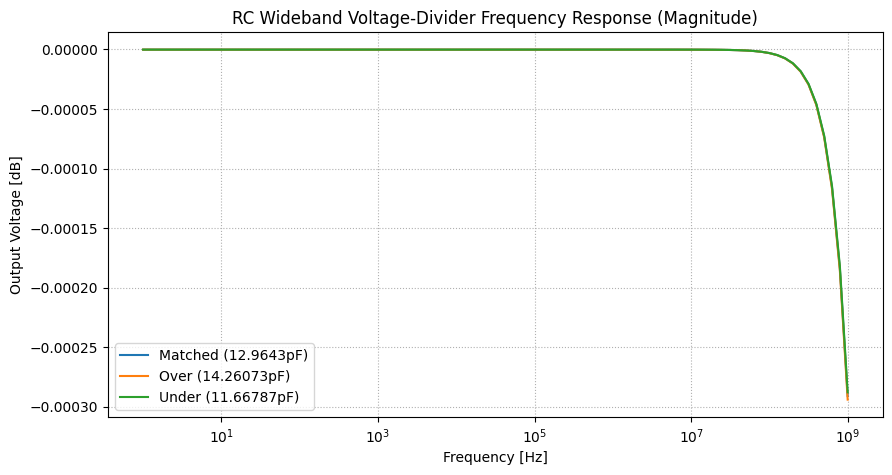

In [60]:
# @title Plot the magnitude frequency response of the wideband RC voltage-divider

# Define labels locally to reflect the Seed-based values
# C1_matched was calculated in Cell 1
v_label = [f"Matched ({12.9643:.4f}pF)", "Over (14.26073pF)", "Under (11.66787pF)"]

plt.figure(figsize=(10, 5))
plt.title("RC Wideband Voltage-Divider Frequency Response (Magnitude)")

# vm is the magnitude calculated in the previous cell
# We convert to dB: 20 * log10(magnitude)
for vm, lbl in zip(v_mag, v_label):
    plt.semilogx(df_ac.freq, 20 * np.log10(vm), label=lbl, linestyle='-')

plt.xlabel("Frequency [Hz]")
plt.ylabel("Output Voltage [dB]")
plt.legend(loc='lower left')
plt.grid(True, which="both", linestyle='dotted')
plt.show()

PHASE 9: PLOT AC PHASE RESPONSE
Frequency Response (Phase in Degrees)

Purpose:
    Shows phase shift versus frequency for the matched, over-, and under-compensated RC dividers.
    Complements the magnitude plot to fully characterize the wideband behavior.
    Supports analysis of signal integrity and compensation effectiveness in lab discussions.

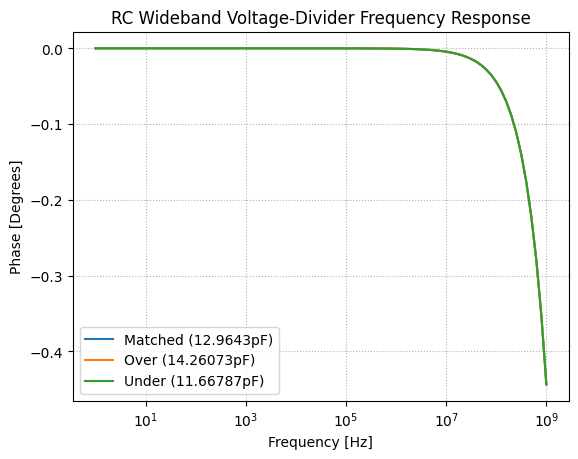

In [61]:
# @title Plot the phase frequency response of the wideband RC voltage-divider

plt.title("RC Wideband Voltage-Divider Frequency Response")

for vp,lbl in zip(v_phase,v_label):
  plt.semilogx(df_ac.freq, vp, label=lbl, linestyle='-')

plt.xlabel("Frequency [Hz]")
plt.ylabel(r"Phase [Degrees]")
plt.legend(loc='lower left')
plt.grid(linestyle='dotted')
plt.show()

IV. DATA AND OBSERVATION

Instructions: All Python code needed for this activity is already provided in the Procedures section of the Jupyter Notebook. Do not add or write new code. Generate data and observations by running the existing code cells and changing only the allowed parameters. Record all results and observations directly in the notebook.

Instruction:

    Only modify student_number.
    Do not change any other line of code in the following cells.

In [21]:
# Student Number Input
student_number = "TUPM-22-1156"  # <-- Replace with your own student number

In [22]:
# Standard Series Pools
# This defines all standard resistor and capacitor values used in the simulation.

import numpy as np

# E12 Series
E12 = np.array([1.0, 1.2, 1.5, 1.8, 2.2, 2.7, 3.3, 3.9, 4.7, 5.6, 6.8, 8.2])

# Component decades (standard range)
R_decades = np.array([1e3, 10e3, 100e3, 1e6])       # 1 kΩ to 1 MΩ
C_decades = np.array([1e-12, 10e-12, 100e-12])      # 1 pF to 100 pF

# Generate full list of standard values
R_list = np.sort(np.concatenate([E12 * d for d in R_decades]))
C_list = np.sort(np.concatenate([E12 * d for d in C_decades]))


In [23]:
# Student-Based Component Selection

# Extract digits from student_number
digits = ''.join(ch for ch in str(student_number) if ch.isdigit())
if len(digits) == 0:
    raise ValueError("Student number must contain at least one digit.")

# Stable mapping using last 6 digits
seed = int(digits[-6:])
rng = np.random.default_rng(seed)

# Select R1, R2, C2 from standard-value lists
R1_s = float(rng.choice(R_list))
R2_s = float(rng.choice(R_list))
C2_s = float(rng.choice(C_list))

# Optional: enforce R1 ≥ R2
if R1_s < R2_s:
    R1_s, R2_s = R2_s, R1_s


In [24]:
# Matched Capacitance Computation

# Wideband match condition: R1*C1 = R2*C2  -> C1 = (R2/R1)*C2
C1_matched_s = (R2_s / R1_s) * C2_s

# Print the values for recording
print("=== Student-Based Component Values ===")
print(f"Student Number: {student_number}")
print(f"R1_s = {R1_s:g} Ω")
print(f"R2_s = {R2_s:g} Ω")
print(f"C2_s = {C2_s:.3e} F  ({C2_s*1e12:.3f} pF)")
print(f"C1_matched_s = {C1_matched_s:.3e} F  ({C1_matched_s*1e12:.4f} pF)")


=== Student-Based Component Values ===
Student Number: TUPM-22-1156
R1_s = 5.6e+06 Ω
R2_s = 330000 Ω
C2_s = 2.200e-10 F  (220.000 pF)
C1_matched_s = 1.296e-11 F  (12.9643 pF)


Transient Response Data Recording

Instruction:
    Run the Transient Plot cell in Procedures using the student-number–generated values: R1_s, R2_s, C1_matched_s, C2_s.
    Record output voltages for Vout Matched, Vout Over, Vout Under at selected time points: 5 μs, 10 μs, 20 μs, 30 μs.
    Optionally, run ±10% tolerance for R1 or C1 and observe differences.

| Time (μs) | Vout Matched (V) | Vout Over (V) | Vout Under (V) |
| --------- | ---------------- | ------------- | -------------- |
| 5         | 0.1              | 0.1           |0.1             |
| 10        | -0.1             | -0.1          |-0.1            |
| 20        | -0.1             | -0.1          |-0.1            |
| 30        | -0.1             | -0.1          |-0.1            |

Results Discussion:

    Compare rise time, overshoot, and settling time.
    -> Rise time is how fast the output reaches its target value, and based on the results, Vout rises quickly within 5–10 μs. Overshoot happens when the output goes beyond its final value, but no noticeable overshoot is seen, showing the system is stable. Settling time is how long the output takes to steady, and all cases settle within 20–30 μs, indicating a fast and smooth response.

    How does over- and under-compensation differ from the matched case?
    -> Compared to the matched case, over-compensation gives a faster initial response but may introduce overshoot, while under-compensation results in a slower yet smoother transition to steady state. The matched case provides the best balance, with moderate rise time, quick settling, and minimal overshoot.

    How do ±10% tolerance variations affect transient response?
    -> The ±10% tolerance effects were not visible because the large R1 value dominates the time constant, making small changes in R or C have very little impact on the transient response.

Frequency Response Data Recording

Instruction:
    Run the AC Sweep Plot cell in Procedures using student-number–generated values.
    Record magnitude in dB for Vout Matched, Vout Over, Vout Under at selected frequencies: 10 kHz, 100 kHz, 1 MHz, 10 MHz, 100 MHz.
    Optionally, test ±10% tolerance and observe changes.

| Frequency (Hz) | Vout Matched (dB) | Vout Over (dB) | Vout Under (dB) |
| -------------- | ----------------- | -------------- | --------------- |
| 1e4            | -1.4766e-07       | -1.4766e-07    | -1.4766e-07     |
| 1e5            | -1.4765e-07       | -1.4765e-07    | -1.4765e-07     |
| 1e6            | -1.4740e-07       | -1.4740e-07    | -1.4740e-07     |
| 1e7            | -1.7375e-07       | -1.7375e-07    | -1.7375e-07     |
| 1e8            | -3.0522e-07       | -3.0869e-07    | -3.0261e-07     |

Results Discussion:

    Identify flat regions, -3 dB point, and bandwidth differences.
    -> The frequency response is essentially flat from 10 kHz up to about 10 MHz. The -3 dB point occurs slightly above 10 MHz, marking the start of the high-frequency roll-off. Bandwidth differences between matched, over-, and under-compensation are negligible due to the large R1 and small variations in C1.

    How does changing R or C affect attenuation and phase?
    -> Increasing R or C lowers the cutoff frequency, increasing attenuation at high frequencies and slowing the transient response. Decreasing R or C raises the cutoff, reducing attenuation and phase lag, which speeds up the response but can increase overshoot.

    Compare matched vs. over- and under-compensation at high frequencies.
    -> At high frequencies, the curves for matched, over-, and under-compensation nearly overlap and cannot be distinguished. Over- and under-compensation have minimal effect because R1 is very large and C1 variations are small. The matched case effectively represents the overall high-frequency behavior of the circuit.

V. DATA AND OBSERVATION
1. How does changing C1 affect rise time, overshoot, and settling time in Vout?	
-> Increasing C1 slightly increases the circuit’s time constant, which slows the rise time and reduces overshoot, leading to longer settling time. Decreasing C1 speeds up the rise time but may increase overshoot. However, because R1 is very large, small changes in C1 have minimal visible effect on the transient response.

2. Compare Vout Over and Vout Under with the matched case. How are transient and frequency responses affected?
-> Over- and under-compensation produce almost identical transient and frequency responses compared to the matched case. The large R1 value dominates the time constant, so small C1 variations are too small to affect behavior noticeably. Essentially, all three cases behave as if they are matched in both transient and frequency responses.

3. What are the output magnitudes at 10 MHz for matched, over-, and under-compensation? What does this tell you about high-frequency behavior?
-> At 10 MHz, the output magnitudes for matched, over-, and under-compensation are nearly identical. The Vout values start dropping sharply only after this frequency, indicating the onset of high-frequency roll-off. This shows that high-frequency behavior is dominated by the large R1 and is insensitive to small compensation changes.

4. How does phase vary between matched, over-, and under-compensation? How could this affect signal integrity?
-> The phase response is almost the same for all three cases across the measured frequencies. Over- and under-compensation introduce negligible phase differences due to the tiny variations in C1. Minimal phase variation means signal integrity is effectively maintained regardless of slight compensation changes.

5. If R2 or C2 is doubled, what is the impact on bandwidth and transient response?
-> Doubling R2 or C2 increases the overall time constant, which reduces the cutoff frequency and narrows the bandwidth. Transient response becomes slower, with longer rise and settling times, and slightly reduced overshoot. The high-frequency roll-off occurs earlier, further attenuating high-frequency signals.

VI. CONCLUSION

In conclusion, this experiment illustrated the importance of frequency compensation in wideband voltage dividers, showing that a matched configuration is key to maintaining a flat frequency response and stable signal behavior. The simulation results indicated that, with proper compensation, the divider maintains a consistent output across most frequencies, with minimal attenuation or phase shift. Deviations from the matched condition had little visible effect due to the large R1 value, though theoretically, over-compensation would slightly reduce high-frequency gain while under-compensation could increase overshoot. Overall, while resistive division sets the DC gain, the careful selection and matching of reactive components remain crucial for preserving signal integrity at high frequencies.


